In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from functools import partial
from itertools import product
from lightgbm import LGBMRegressor
from sklearn.linear_model import ElasticNet, SGDClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
import re
import time
import datetime

from my_modules.plot_and_stat_funcs import *
from my_modules.transformations import *

In [2]:
data_folder = 'data/'

Reading the data

In [3]:
X_train = pd.read_csv(data_folder + 'X_train.csv')
y_train = pd.read_csv(data_folder + 'y_train.csv').target
X_val = pd.read_csv(data_folder + 'X_val.csv')
y_val = pd.read_csv(data_folder + 'y_val.csv').target
X_test = pd.read_csv(data_folder + 'X_test.csv')
test = pd.read_csv(data_folder + 'test.csv')
submission = pd.read_csv(data_folder + 'sample_submission.csv')

In [4]:
X_train.head(1)

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,ordered_day,ordered_week,ordered_month,MonthOfYear,Promo2,...,Assortment_c,EncodedDistance,EncodedCompetitionMonthsFromStart,EncodedPromo2WeeksFromStart,PromoInterval_,"PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Feb,May,Aug,Nov","PromoInterval_Mar,Jun,Sept,Dec",Encoded_Customers,Encoded_sum_target
0,1,6,0,0,0,893,127,29,5,0,...,0.0,-0.321681,0.940159,0.0,1.0,0.0,0.0,0.0,-0.362074,-0.900261


All stores that are present in the test dataset

In [5]:
test_store_ids = test.Store.unique()

Removing the data about stores that are absent in the test dataset. Also drop 'Store' column as it is an identifier.

In [6]:
is_train_in_test_mask = X_train.Store.isin(test_store_ids)
X_train = X_train[is_train_in_test_mask]
train_stores = X_train.Store
X_train.drop(columns='Store', inplace=True)
y_train = y_train[is_train_in_test_mask]

is_val_in_test_mask = X_val.Store.isin(test_store_ids)
X_val = X_val[is_val_in_test_mask]
val_stores = X_val.Store
X_val.drop(columns='Store', inplace=True)
y_val = y_val[is_val_in_test_mask]

test_stores = X_test.Store
X_test.drop(columns='Store', inplace=True)

As light GBM allows only alphanumeric characters and underscores in column names remove other characters.

In [7]:
X_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x), inplace=True)
X_val.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x), inplace=True)
X_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x), inplace=True)

In [8]:
X_train.head(1)

,DayOfWeek,Promo,StateHoliday,SchoolHoliday,ordered_day,ordered_week,ordered_month,MonthOfYear,Promo2,StoreType_a,...,Assortment_c,EncodedDistance,EncodedCompetitionMonthsFromStart,EncodedPromo2WeeksFromStart,PromoInterval_,PromoInterval_JanAprJulOct,PromoInterval_FebMayAugNov,PromoInterval_MarJunSeptDec,Encoded_Customers,Encoded_sum_target
0,6,0,0,0,893,127,29,5,0,0.0,...,0.0,-0.321681,0.940159,0.0,1.0,0.0,0.0,0.0,-0.362074,-0.900261


In [9]:
def RMSPE(y_true, y_pred):
    """
    The metric of current task.
    As zero values are ignored these values must be removed from arrays.
    """
    y_t, y_p = np.array(y_true), np.array(y_pred)
    y_t, y_p = y_t[np.abs(y_t) > 1e-3], y_p[np.abs(y_t) > 1e-3]
    return np.sqrt(np.mean(
        ((y_t - y_p) / y_t)**2
    ))

In [10]:
def all_info_about_model(model_init, X_train, y_train, X_val, y_val, metric, param_grid, include_train=True, show_loop_params=True, *fit_args, **fit_kwargs):
    """
    Returns the table with information about training the model on train and validation datasets.
    X_train and y_train are used for training the model. X_val and y_val are used for validating.
    The table contains parameters' values that were used in training and validating, the metric values calculated
    on the train and validation datasets and the evaluation time. 
    
    Parameters
    ----------
    model_init : function
        The init function of model for tuning. It must return the model that has 'fit' and 'predict' methods.
    
    X_train : array-like or sparse matrix of shape = [n_samples, n_features]
        Dataset that is used for training the model.

    y_train : array-like of shape = [n_samples]
        Target values that are used for training the model.
        
    X_val : array-like or sparse matrix of shape = [n_samples, n_features]
        Dataset that is used for validating the model.

    y_val : array-like of shape = [n_samples]
        Target values that are used for validatin the model
    
    metric : callable
        Function with the signature func(y_true, y_pred) -> non-negative number.
    
    param_grid : dict
        Dictionary with parameters names (`str`) as keys and lists of parameter settings to try as values
    
    include_train : boolean
        If True, then the train score is included in result dataframe. Otherwise it is not included.
        
    show_loop_params : boolean
        If True, then each grid parameters set is printed before training. Otherwise it is not printed.
        It is used to control the number of parameters' sets that were used.
    
    *fit_args, **fit_kwargs:
        Parameters that are used in 'fit' method.
    
    """
    param_names = list(param_grid.keys())
    param_values = list(product(*list(param_grid.values())))
    scores_df = pd.DataFrame(param_values, columns=param_names)
    if include_train:
        train_scores = []
    val_scores = []
    eval_time = []
    for i, param_value in enumerate(param_values):
        start = time.time()
        params = dict(zip(param_names, param_value))
        if show_loop_params:
            print('\n', params, '\n')
        model = model_init(**params)
        model.fit(X_train, y_train, *fit_args, **fit_kwargs)
        if include_train:
            train_scores.append(metric(y_train, model.predict(X_train)))
        val_scores.append(metric(y_val, model.predict(X_val)))
        eval_time.append(time.time() - start)
    
    if include_train:
        scores_df.loc[:, 'train_metric'] = train_scores
    scores_df.loc[:, 'val_metric'] = val_scores
    scores_df.loc[:, 'eval_time (sec)'] = eval_time
    
    return scores_df

In [11]:
def plot_eval_results(x, data):
    """
    The function plot the results of the previous function.
    
    Parameters
    ----------
    x : str
        The parameter that was tuned.
    
    data : pandas.DataFrame
        The dataframe as the result of the previous function
    """
    plt.figure(figsize=(12, 7))
    plt.plot(data[x], data['train_metric'])
    plt.plot(data[x], data['val_metric'])
    plt.legend(['train_rmspe', 'val_rmspe'])
    plt.xlabel(x)
    plt.ylabel('rmspe')
    plt.title(f'rmspe on train and validation datasets depending on {x}')
    plt.xticks(ticks=data[x], labels=data[x])
    plt.show()

# LGBM

Let's tune the parameters for lightGBM model for origin target.

## Origin target

Here I tune the max_depth parameter. The num_leaves is set because its default value is 31 that is too low for trees whose depths are about 10.

In [ ]:
max_depth_results = all_info_about_model(partial(LGBMRegressor, num_leaves=1000, n_estimators=1000, random_state=205,),
                     X_train, y_train, X_val, y_val, RMSPE,
                     {
                         'max_depth': [-1] + list(range(1, 14)),
                     },
                     show_loop_params=True,
)

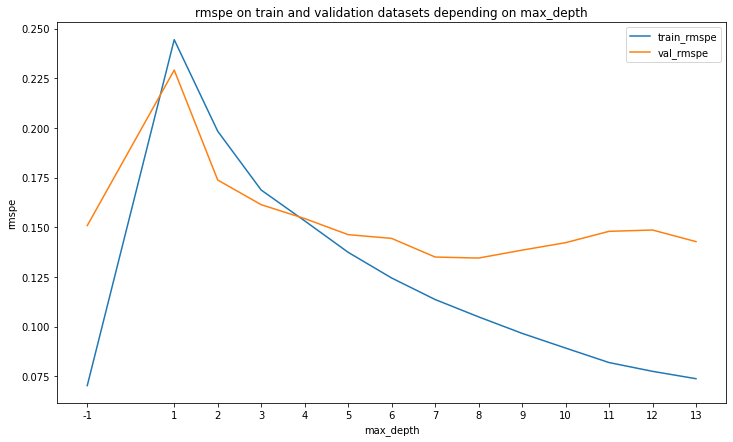

In [ ]:
plot_eval_results('max_depth', max_depth_results)

So the best results are in cases when max_depth parameter equal 7 or 8. For the further tuning I also include the values 6 and 9 because they the close result.

Here I tune the num_leaves parameter. I left the default value of max_depth parameter is -1 (there are no constraints).

In [ ]:
num_leaves_results = all_info_about_model(partial(LGBMRegressor, n_estimators=1000, random_state=205,),
                     X_train, y_train, X_val, y_val, RMSPE,
                     {
                         'num_leaves': list(range(10, 121, 10)),
                     },
                     show_loop_params=True,
)

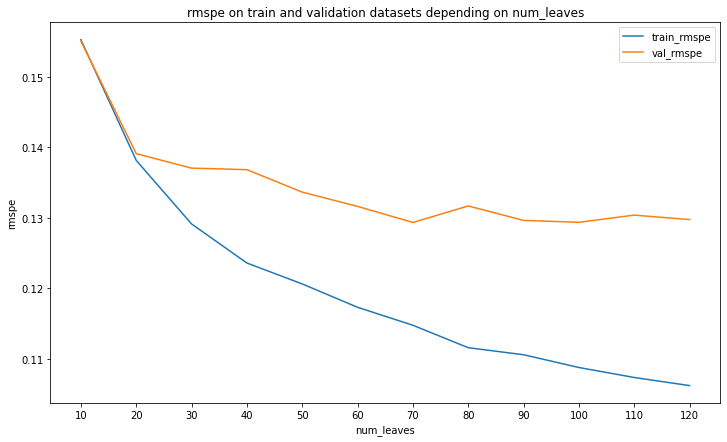

In [ ]:
plot_eval_results('num_leaves', num_leaves_results)

The best results are for cases when num_leaves is around 70. So for the further tuning I include values 60, 70, 80, 90.

Here I want to know what combination of the previous parameters has the best result.

In [ ]:
max_depth_num_leaves_results = all_info_about_model(partial(LGBMRegressor, n_estimators=1000, random_state=205, ),
                     X_train, y_train, X_val, y_val, RMSPE,
                     {
                         'max_depth': [-1, 6, 7, 8, 9],
                         'num_leaves': [60, 70, 80, 90],
                     },
                     show_loop_params=True,
)

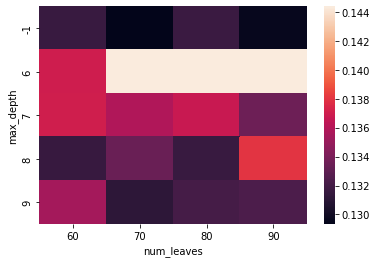

In [ ]:
sns.heatmap(max_depth_num_leaves_results.set_index(['max_depth', 'num_leaves']).unstack()['val_metric'])
plt.show()

In [ ]:
max_depth_num_leaves_results.loc[[max_depth_num_leaves_results.val_metric.argmin()]]

,max_depth,num_leaves,train_metric,val_metric,eval_time (sec)
1,-1,70,0.114745,0.129346,77.202977


So the best parameters are max_depth=-1 and num_leaves=70

And now let's tune the learning_rate parameter. Here I chose the best combination of max_depth and num_leaves parameters. Also I increased the number of estimators and decided to use early stopping because the small values of learning_rate make the training slower.

In [ ]:
learning_rate_results = all_info_about_model(partial(LGBMRegressor, max_depth=-1, num_leaves=70, n_estimators=5000, random_state=205, ),
                     X_train, y_train, X_val, y_val, RMSPE,
                     {
                         'learning_rate': np.linspace(0.05, 0.15, 11),
                     },
                     eval_set=[(X_val, y_val)],
                     eval_metric=lambda y_true, y_pred: ('RMSPE', RMSPE(y_true, y_pred), False),
                     early_stopping_rounds=150,
                     verbose=100,
                     show_loop_params=True,
)

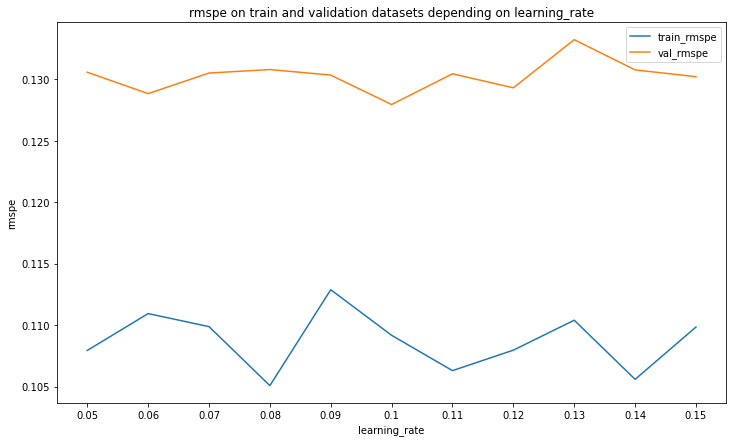

In [ ]:
plot_eval_results('learning_rate', learning_rate_results)

Let's see the row with minimum rmspe.

In [ ]:
learning_rate_results.loc[[learning_rate_results.val_metric.argmin()]]

,learning_rate,train_metric,val_metric,eval_time (sec)
5,0.1,0.109168,0.127942,120.04615


The best params are max_depth=-1, num_leaves=70, learning_rate=0.1

## Transformed target

Now let's see how the transformation of target help for prediction. I use the Box-Cox transformation because ...

Box-Cox transformation  
$
z = \begin{cases}
\frac{(y+a)^\mu - 1}{\mu}, \mu \ne 0\\
ln(y+a), \mu=0
\end{cases}
$

Inverse Box-Cox transformation  
$
y = \begin{cases}
(1 + \mu\cdot z)^\frac{1}{\mu}, \mu \ne 0\\
e^z-a, \mu=0
\end{cases}
$

In [12]:
def box_cox(y, mu, shift=0.0):
    """
    Box-Cox transformation
    """
    if mu == 0.0:
        return np.log(y + shift)
    return ((y + shift)**mu - 1) / mu

def inv_box_cox(z, mu, shift=0.0):
    """
    Inverse Box-Cox transformation
    """
    if mu == 0.0:
        return np.e**z - shift
    return (1 + z * mu)**(1 / mu) - shift

def box_cox_RMSPE(y_true, y_pred, mu, shift):
    """
    RMSPE for transformed vectors using Box-Cox
    """
    return RMSPE(inv_box_cox(y_true, mu, shift), inv_box_cox(y_pred, mu, shift))

Here I "tune" the parameter of target transformation.

In [ ]:
boxcox_scores = []
mus = np.linspace(0, 1, 21)
for mu in mus:
    print('mu:', mu, '\n')
    shift = 1
    y_train_boxcox = box_cox(y_train, mu, shift)
    y_val_boxcox = box_cox(y_val, mu, shift)
    
    lgbm_boxcox = LGBMRegressor(num_leaves=70, max_depth=-1, learning_rate=0.1, n_estimators=5000, random_state=205)
    lgbm_boxcox.fit(X_train, y_train_boxcox,
                                        eval_set=[(X_val, y_val_boxcox)],
                            eval_metric=lambda y_true, y_pred: ('RMSPE', box_cox_RMSPE(y_true, y_pred, mu, shift), False),
                                        early_stopping_rounds=150,
                                        verbose=100,
    )
    boxcox_scores.append(box_cox_RMSPE(y_val_boxcox, lgbm_boxcox.predict(X_val), mu, shift))

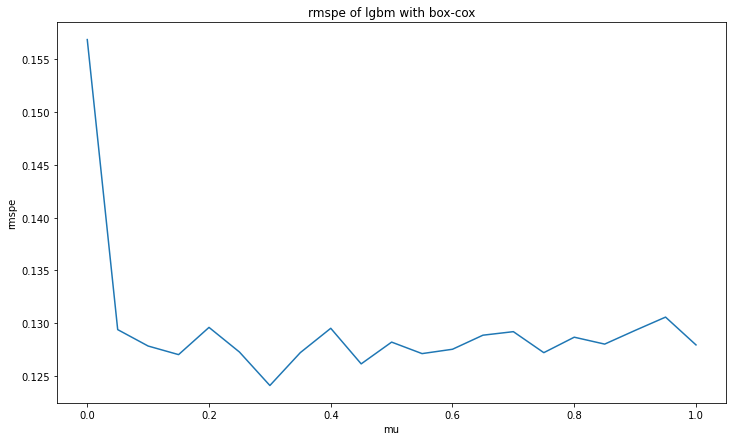

In [ ]:
plt.figure(figsize=(12, 7))
plt.plot(mus, boxcox_scores)
plt.xlabel('mu')
plt.ylabel('rmspe')
plt.title('rmspe of lgbm with box-cox')
plt.show()

In [ ]:
print('The minimum rmspe:', min(boxcox_scores))
print('The mu parameter:', mus[np.argmin(boxcox_scores)])

The minimum rmspe: 0.12409362139537163
The mu parameter: 0.30000000000000004


The rmspe for origin target is 0.127942. So the transformation is useful

In [ ]:
mu = 0.3
shift = 1
y_train_boxcox = box_cox(y_train, mu, shift)
y_val_boxcox = box_cox(y_val, mu, shift)

# Linear Regression

The loss function is $L(y, z) = \sum\limits_{i=1}^{n}\frac{(y_i-z_i)^2}{y_i^2}$, where y and z - true and predicted targets. It can be written as $L(y, z)=\sum\limits_{i=1}^{n}\frac{1}{y_i^2}(y_i-z_i)^2$. So it can be used in training the linear regression with weights equal inverse squares of targets.

In [ ]:
X_train.head()

,DayOfWeek,Promo,StateHoliday,SchoolHoliday,ordered_day,ordered_week,ordered_month,MonthOfYear,Promo2,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,EncodedDistance,EncodedCompetitionMonthsFromStart,EncodedPromo2WeeksFromStart,PromoInterval_,PromoInterval_JanAprJulOct,PromoInterval_FebMayAugNov,PromoInterval_MarJunSeptDec,Encoded_Customers,Encoded_sum_target
0,6,0,0,0,893,127,29,5,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,-0.321681,0.940159,0.0,1.0,0.0,0.0,0.0,-0.362074,-0.900261
1,5,0,0,0,892,127,29,5,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,-0.321681,0.940159,0.0,1.0,0.0,0.0,0.0,-0.362074,-0.900261
2,4,0,0,0,891,127,29,5,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,-0.321681,0.940159,0.0,1.0,0.0,0.0,0.0,-0.362074,-0.900261
3,3,0,0,0,890,127,29,5,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,-0.321681,0.940159,0.0,1.0,0.0,0.0,0.0,-0.362074,-0.900261
4,2,0,0,0,889,127,29,5,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,-0.321681,0.940159,0.0,1.0,0.0,0.0,0.0,-0.362074,-0.900261


As there are features that have relatively big values let's standartize them.

In [ ]:
cols_to_normalize = ['DayOfWeek', 'ordered_day', 'ordered_week', 'ordered_month']
scaler = MinMaxScaler()

X_train_norm = X_train.copy()
X_train_norm.loc[:, cols_to_normalize] = scaler.fit_transform(X_train_norm[cols_to_normalize])

X_val_norm = X_val.copy()
X_val_norm.loc[:, cols_to_normalize] = scaler.transform(X_val_norm[cols_to_normalize])

In [ ]:
X_train_norm.head()

,DayOfWeek,Promo,StateHoliday,SchoolHoliday,ordered_day,ordered_week,ordered_month,MonthOfYear,Promo2,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,EncodedDistance,EncodedCompetitionMonthsFromStart,EncodedPromo2WeeksFromStart,PromoInterval_,PromoInterval_JanAprJulOct,PromoInterval_FebMayAugNov,PromoInterval_MarJunSeptDec,Encoded_Customers,Encoded_sum_target
0,0.833333,0,0,0,1.000000,1.0,1.0,5,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,-0.321681,0.940159,0.0,1.0,0.0,0.0,0.0,-0.362074,-0.900261
1,0.666667,0,0,0,0.998880,1.0,1.0,5,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,-0.321681,0.940159,0.0,1.0,0.0,0.0,0.0,-0.362074,-0.900261
2,0.500000,0,0,0,0.997760,1.0,1.0,5,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,-0.321681,0.940159,0.0,1.0,0.0,0.0,0.0,-0.362074,-0.900261
3,0.333333,0,0,0,0.996641,1.0,1.0,5,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,-0.321681,0.940159,0.0,1.0,0.0,0.0,0.0,-0.362074,-0.900261
4,0.166667,0,0,0,0.995521,1.0,1.0,5,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,-0.321681,0.940159,0.0,1.0,0.0,0.0,0.0,-0.362074,-0.900261


Let's remove the rows with targets equals 0 because they are not used in loss function.

In [ ]:
X_train_norm_nonzero = X_train_norm[y_train != 0]
y_train_norm_nonzero = y_train[y_train != 0]

X_val_norm_nonzero = X_val_norm[y_val != 0]
y_val_norm_nonzero = y_val[y_val != 0]

In [ ]:
lin_reg = ElasticNet()
lin_reg.fit(X_train_norm_nonzero, y_train_norm_nonzero, sample_weight=1/y_train_norm_nonzero**2)
lin_reg_predicted = lin_reg.predict(X_val_norm_nonzero)

In [ ]:
RMSPE(y_val_norm_nonzero, lin_reg_predicted)

0.2668527236908827

The error is greater than for lightGBM.

# kNN

For using the k-neighbors model the data should be standartize or normalize. It was been done when training the linear regression. So I will use it.

In [ ]:
knn_scores = []
knn_n_neighbors = range(2, 17, 2)
for n_neighbors in knn_n_neighbors:
    print('n_neighbors:', n_neighbors, '\n')
    knn = KNeighborsRegressor(n_neighbors=n_neighbors)
    knn.fit(X_train_norm, y_train)
    knn_predicted = knn.predict(X_val_norm)
    knn_scores.append(RMSPE(y_val, knn_predicted))

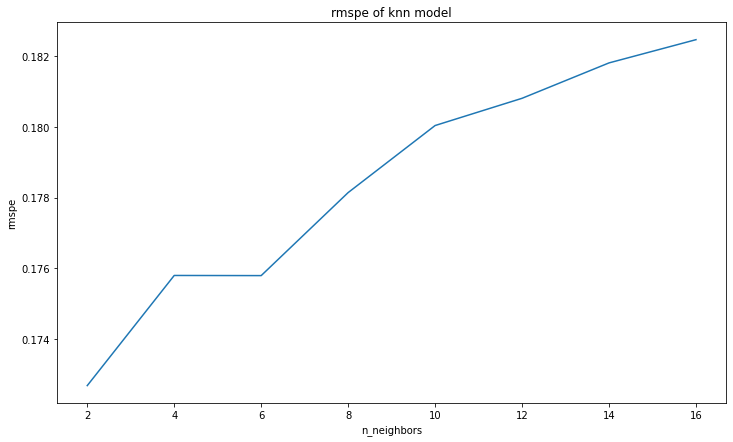

In [23]:
plt.figure(figsize=(12, 7))
plt.plot(knn_n_neighbors, knn_scores)
plt.xlabel('n_neighbors')
plt.ylabel('rmspe')
plt.title('rmspe of knn model')
plt.xticks(ticks=knn_n_neighbors, labels=knn_n_neighbors)
plt.show()

The error is about 0.172 which is between linear regression and lightGBM. So for submitting I will use the lgbm.

# Submitting

In [20]:
X = pd.concat([X_train, X_val], ignore_index=True)
y = pd.concat([y_train, y_val], ignore_index=True)

In [21]:
mu_best = 0.3

The number of estimators equals 1447 because it was the best iteration for the best model when tuning the box-cox parameters.

In [22]:
lgbm_final = LGBMRegressor(num_leaves=70, max_depth=-1, learning_rate=0.1, n_estimators=1447, random_state=205)
lgbm_final.fit(X, box_cox(y, mu=mu_best, shift=1.0),)

LGBMRegressor(n_estimators=1447, num_leaves=70, random_state=205)

In [23]:
train_prediction = inv_box_cox(lgbm_final.predict(X_train), mu=mu_best, shift=1.0)
val_prediction = inv_box_cox(lgbm_final.predict(X_val), mu=mu_best, shift=1.0)
test_prediction = inv_box_cox(lgbm_final.predict(X_test), mu=mu_best, shift=1.0)

RMSPE on train dataset

In [24]:
RMSPE(y_train, train_prediction)

0.10086177760789446

RMSPE on validation dataset.

In [25]:
RMSPE(y_val, val_prediction)

0.0782054307208756

saving the submission

In [18]:
train_predict_df = X_train.copy()
train_predict_df.loc[:, 'Store'] = train_stores
train_predict_df.loc[:, 'target'] = y_train

val_predict_df = X_val.copy()
val_predict_df.loc[:, 'Store'] = val_stores
val_predict_df.loc[:, 'target'] = y_val

test_predict_df = X_test.copy()
test_predict_df.loc[:, 'Store'] = test_stores

In [26]:
test['ordered_day'] = test.Date.apply(lambda date: (datetime.datetime.strptime(date, '%Y-%m-%d') - datetime.datetime(2013, 1, 1)).days)

In [27]:
test_predict_df['prediction'] = test_prediction
test_predict_df['Store'] = test_stores

In [28]:
prediction = test[['Id', 'Store', 'ordered_day']].merge(test_predict_df[['Store', 'ordered_day', 'prediction']])[['Id', 'prediction']]

In [29]:
submission = pd.read_csv(data_folder + 'sample_submission.csv')
submission = submission[['Id']].merge(prediction, on='Id', how='left').fillna(0).rename(columns={'prediction': 'Sales'})
submission.to_csv(data_folder + 'submission_lgbm.csv', index=False)

In [30]:
train_predict_df.loc[:, 'full_prediction'] = train_prediction
val_predict_df.loc[:, 'full_prediction'] = val_prediction
test_predict_df.loc[:, 'full_prediction'] = test_prediction

In [14]:
lgbm_best = LGBMRegressor(num_leaves=70, max_depth=-1, learning_rate=0.1, n_estimators=1447, random_state=205)
lgbm_best.fit(X_train, box_cox(y_train, mu=mu_best, shift=1.0),)

LGBMRegressor(n_estimators=1447, num_leaves=70, random_state=205)

In [16]:
train_prediction = inv_box_cox(lgbm_best.predict(X_train), mu=mu_best, shift=1.0)
val_prediction = inv_box_cox(lgbm_best.predict(X_val), mu=mu_best, shift=1.0)
test_prediction = inv_box_cox(lgbm_best.predict(X_test), mu=mu_best, shift=1.0)

In [19]:
train_predict_df.loc[:, 'part_prediction'] = train_prediction
val_predict_df.loc[:, 'part_prediction'] = val_prediction
test_predict_df.loc[:, 'part_prediction'] = test_prediction

In [31]:
train_predict_df[['Store', 'ordered_day', 'ordered_week', 'ordered_month', 'target', 'full_prediction', 'part_prediction']]\
                                                                                    .to_csv(data_folder + 'train_prediction.csv', index=False)
val_predict_df[['Store', 'ordered_day', 'ordered_week', 'ordered_month', 'target', 'full_prediction', 'part_prediction']]\
                                                                                    .to_csv(data_folder + 'val_prediction.csv', index=False)
test_predict_df[['Store', 'ordered_day', 'ordered_week', 'ordered_month', 'full_prediction', 'part_prediction']]\
                                                                                    .to_csv(data_folder + 'test_prediction.csv', index=False)

Final RMSPE - 0.16765

# Error analysis

In [12]:
val_predict_df = pd.read_csv(data_folder + 'val_prediction.csv')

In [22]:
X_train['Store'] = train_stores
X_val['Store'] = val_stores
train_sales = pd.concat([X_train, y_train], axis=1)
val_sales = pd.concat([X_val, y_val], axis=1)
all_sales = pd.concat([train_sales, val_sales], axis=0, ignore_index=True)

Percentage error for each store and day

In [13]:
val_predict_df['percent_error'] = (val_predict_df.part_prediction - val_predict_df.target) / val_predict_df.target

In [14]:
val_predict_df.head()

,Store,ordered_day,ordered_week,ordered_month,target,full_prediction,part_prediction,percent_error
0,1,941,134,30,5263,5579.378131,4726.750395,-0.101890
1,1,940,134,30,5020,4817.362769,4645.220685,-0.074657
2,1,939,134,30,4782,4656.170947,4708.559463,-0.015358
3,1,938,134,30,5011,4962.568145,5157.718730,0.029279
4,1,937,133,30,6102,5614.387827,5503.876083,-0.098021


RMSPE for each store

In [15]:
rmspes = val_predict_df.groupby('Store').agg({'percent_error': lambda err: np.sqrt(np.mean(err**2))}).rename(columns={'percent_error': 'rmspe'})

The histogram of errors

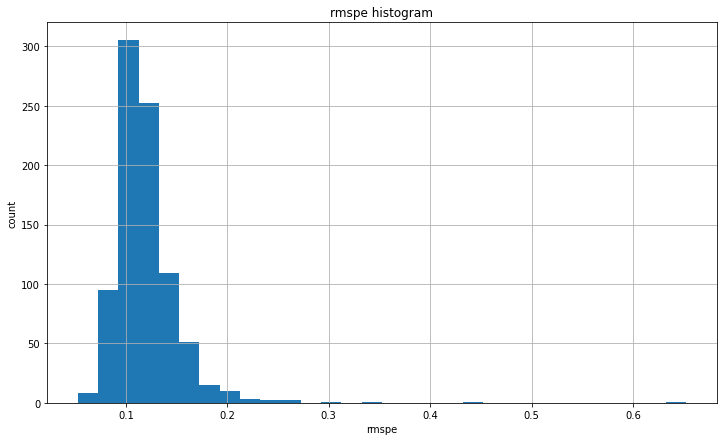

In [16]:
plt.figure(figsize=(12, 7))
rmspes.rmspe.hist(bins=30)
plt.xlabel('rmspe')
plt.ylabel('count')
plt.title('rmspe histogram')
plt.show()

There are some outliers. Let's see the stores with the highest and the lowest errors.

In [17]:
rmspes.sort_values(by='rmspe')

,rmspe
Store,
259,0.052395
733,0.058996
562,0.063103
1097,0.063307
615,0.066952
...,...
183,0.269344
722,0.304086
550,0.351802


Stores with the lowest error

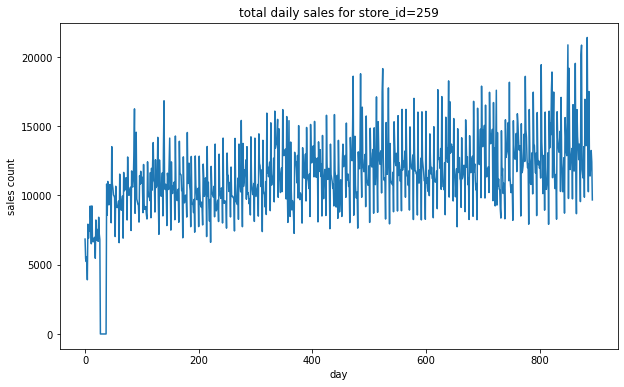

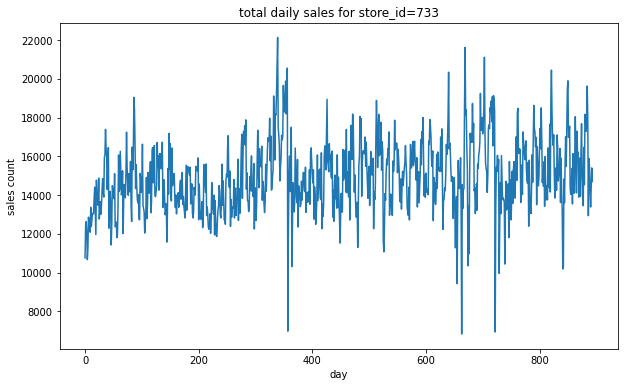

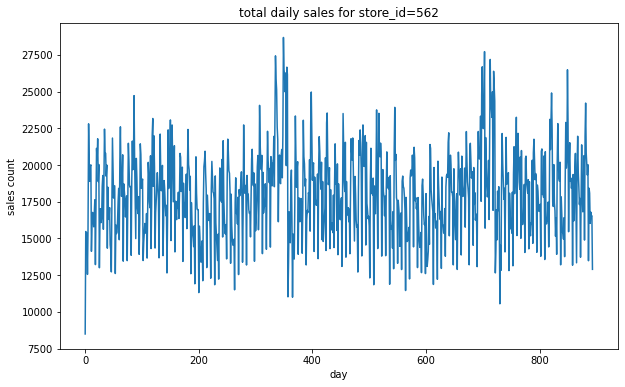

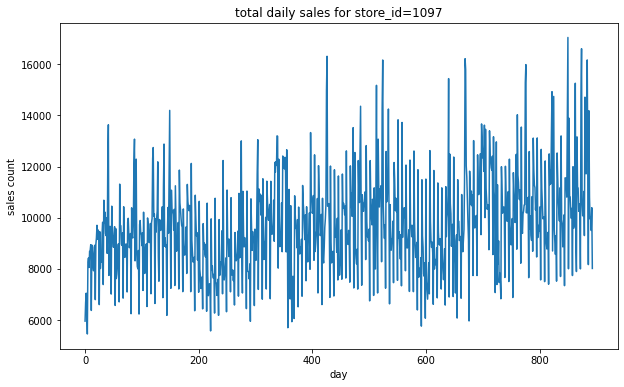

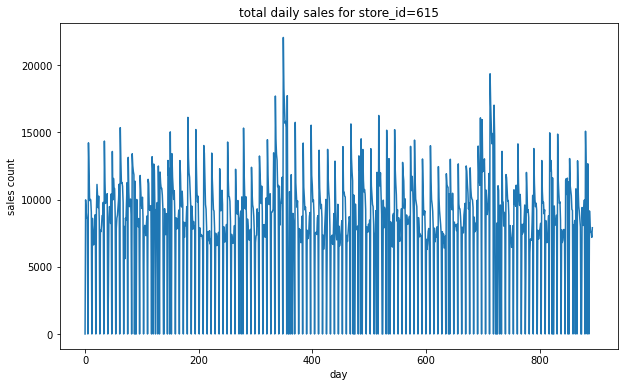

In [23]:
for store_id in rmspes.sort_values(by='rmspe').iloc[:5].index:
    plot_time_series(train_sales, store_id=store_id, time_range='day')

Four of them has the time series almost without zeros. It means that these stores work without weeekends. So probably the stores without weekends are predicted in the best way.

Stores with the highest error

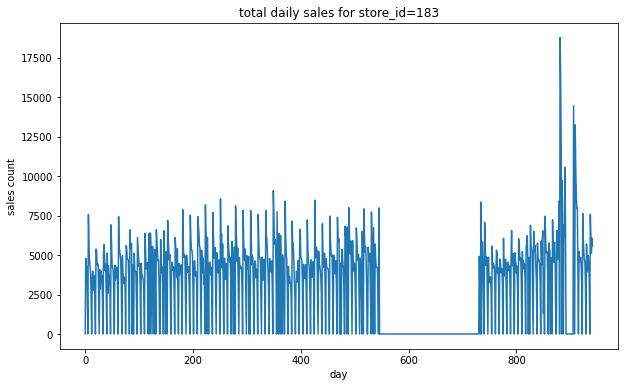

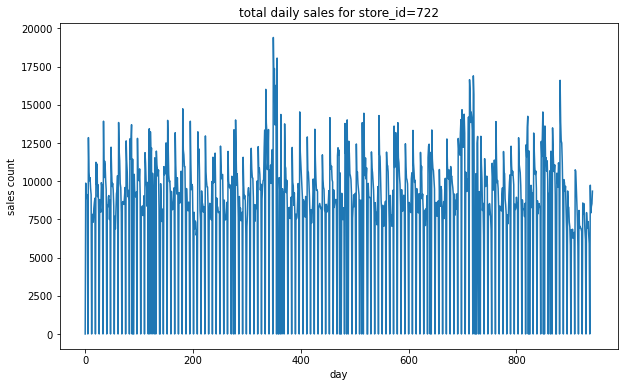

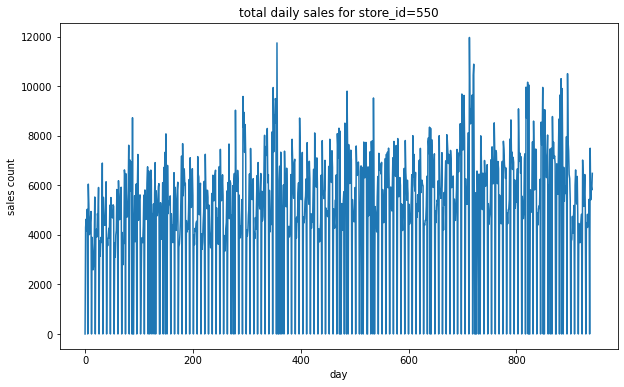

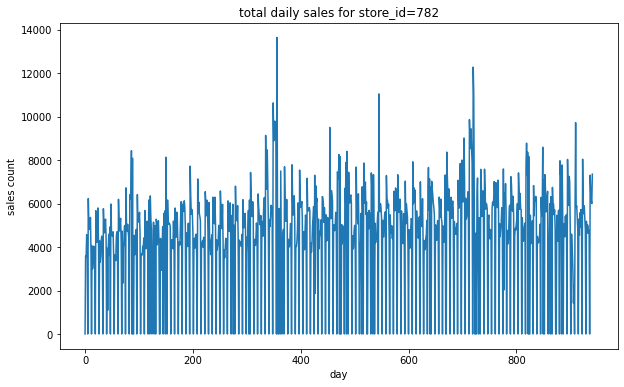

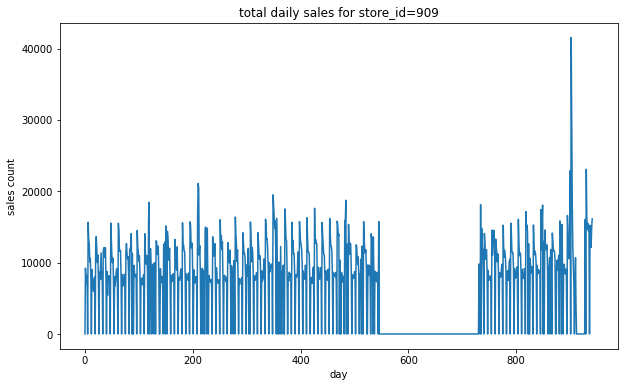

In [24]:
for store_id in rmspes.sort_values(by='rmspe').iloc[-5:].index:
    plot_time_series(all_sales, store_id=store_id, time_range='day')

Two of these stores have periods when there were no sales. The others look like as usual. Probably if there is a period without sales the prediction is less accurate.